## Supplement 4: Classification

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 4.3 Programming Task: Song popularity prediction using Logistic regression
The datasets __train-songs.csv__ and __test-songs.csv__ contain audio properties of various tracks collected from the music streaming site Spotify.


The goal of the task is to train a logistic regression classifier that predicts if
a given track is popular or not.
The dataset consists of 9 columns.
The first 8 columns contain various audio properties
which are provided as input features to the model.
The last column contains the class labels given by 0(not popular) and 1(popular).

i\. Implement the loss function and its gradient for the logistic regression model.
 

In [2]:

train_dataset_pd = pd.read_csv("train-songs.csv")

def prepare_dataset(dataset_pd, cols=["danceability","key","loudness","acousticness","instrumentalness","liveness","valence","tempo"]):
    train_X = train_dataset_pd[cols].to_numpy()
    train_y = train_dataset_pd["popular"].to_numpy()
    train_y = train_y.reshape((len(train_y), 1))

    mean = np.mean(train_X, axis=0)
    std = np.std(train_X, axis=0)

    train_X = (train_X - mean) / std
    return train_X, train_y

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def loss(X, y, w):
    return np.mean(-y * np.log(sigmoid(X @ w)) - (1 - y) * np.log(1 - sigmoid(X @ w)))

def loss_gradient(X, y, w):
    return np.mean((y - sigmoid( X @ w)) * X, axis=0).reshape((len(w), 1))

   ii\. Using the gradient descent algorithm, train the logistic regression model.
You may reuse/modify the gradient descent algorithm from the previous supplement.




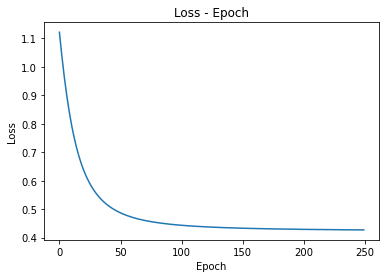

In [3]:

epochs = 250
learning_rate = 0.1

def fit(epochs, learning_rate, X, y):
    losses = np.zeros(epochs)
    w = np.random.randn(len(X[0]), 1)
    for i in range(epochs):
        losses[i] = loss(X, y, w)
        grad = loss_gradient(X, y, w)
        w += learning_rate * grad
    return w, losses


train_X, train_y = prepare_dataset(train_dataset_pd)

trained_w, losses = fit(epochs, learning_rate, train_X, train_y)
plt.plot(losses)
plt.title("Loss - Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")


def predict(X, w):
    predictions = sigmoid(X @ w)
    return predictions

def threshold_predictions(pred, threshold):
    predictions = pred.copy()
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0
    return predictions


iii\. Using model predictions on __test-songs.csv__, build the confusion
matrix and subsequently calculate the precision, recall, and F1-score for a threshold of 0.4.


In [4]:
test_dataset_pd = pd.read_csv("test-songs.csv")
test_X, test_y = prepare_dataset(train_dataset_pd)

predictions = predict(test_X, trained_w)
class_predictions = threshold_predictions(predictions, 0.4)


def get_confusion_matrix(labels, predictions):
    false_labels = labels < 0.5
    true_labels = labels >= 0.5

    false_predictions = predictions < 0.5
    true_predictions = predictions >= 0.5

    true_negative = np.sum(np.logical_and(false_labels, false_predictions).astype(int))
    false_positive = np.sum(np.logical_and(false_labels, true_predictions).astype(int))
    false_negative = np.sum(np.logical_and(true_labels, false_predictions).astype(int))
    true_positive = np.sum(np.logical_and(true_labels, true_predictions).astype(int))

    return np.array([[true_negative, false_positive], 
                    [false_negative, true_positive]])
    

confusion_mtx = get_confusion_matrix(test_y, class_predictions)

precision = confusion_mtx[1,1] / (confusion_mtx[1,1] + confusion_mtx[0, 1])
recall = confusion_mtx[1,1] / (confusion_mtx[1,1] + confusion_mtx[1, 0])
F1 = 2 * (precision * recall) / (precision + recall)


print("Confusion matrix: \n", confusion_mtx)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", F1)





Confusion matrix: 
 [[6499 3501]
 [ 764 9236]]
Precision:  0.7251315066342153
Recall:  0.9236
F1:  0.8124202841183974


iv\. Plot the ROC curve for the model and calculate the AUC metric of your model.


AUC:  0.8875514250000001


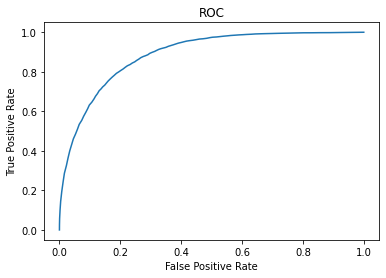

In [5]:
def calculate_integral(x, y):
    l = y[:-1] + y[1:]
    
    d = np.abs(x[1:] - x[:-1])

    trapezoid_areas = l * d / 2
    area = np.sum(trapezoid_areas)
    return area


def compute_ROC(predictions, labels):
    steps = 101
    thresholds = np.linspace(0, 1, steps)
    delta = 1 / (steps - 1)

    false_positives = np.zeros_like(thresholds)
    true_positives = np.zeros_like(thresholds)

    for i, thresh in enumerate(thresholds):
        thresholded_predictions = threshold_predictions(predictions, thresh)
        confusion_mtx = get_confusion_matrix(labels, thresholded_predictions)
        false_positives[i] = confusion_mtx[0, 1]
        true_positives[i] = confusion_mtx[1, 1]
    false_positives /= (confusion_mtx[0, 0] + confusion_mtx[0, 1])
    true_positives /= (confusion_mtx[1, 0] + confusion_mtx[1, 1])

    auc = calculate_integral(false_positives, true_positives)

    return false_positives, true_positives, auc


fp, tp, auc = compute_ROC(predictions, test_y)
plt.plot(fp, tp)
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

print("AUC: ", auc)


v\. Consider the simpler models given below.The input $\mathbf{x}$ in these models takes only 4 input features from the given dataset.

- Model A $~~~~~~~~~~~$   $\mathbf{x}$ = $[$ danceability, key, valence, tempo $]^\top$
- Model B $~~~~~~~~~~~$  $\mathbf{x}$ = $[$ danceability, loudness, acousticness, instrumentalness $]^\top$
- Model C $~~~~~~~~~~~$ $\mathbf{x}$ = $[$ key, liveness, valence, tempo $]^\top$

Train these models using your logistic regression implementation and determine the best performing model using the AUC metric.

AUC:  0.66472319


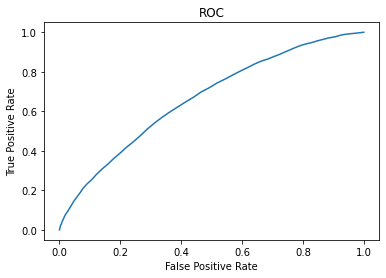

In [6]:
train_X, train_y = prepare_dataset(train_dataset_pd, cols=["danceability", "key", "valence", "tempo"])
test_X, test_y = prepare_dataset(test_dataset_pd, cols=["danceability", "key", "valence", "tempo"])

epochs = 250
lr = 0.1
w, losses = fit(epochs, lr, train_X, train_y)


predictions = predict(test_X, w)
class_predictions = threshold_predictions(predictions, 0.5)

fp, tp, auc = compute_ROC(predictions, test_y)
plt.plot(fp, tp)
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

print("AUC: ", auc)

AUC:  0.887522775


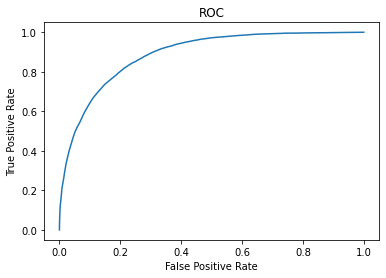

In [7]:
train_X, train_y = prepare_dataset(train_dataset_pd, cols=["danceability", "loudness", "acousticness", "instrumentalness"])
test_X, test_y = prepare_dataset(test_dataset_pd, cols=["danceability", "loudness", "acousticness", "instrumentalness"])

epochs = 250
lr = 0.1
w, losses = fit(epochs, lr, train_X, train_y)


predictions = predict(test_X, w)
class_predictions = threshold_predictions(predictions, 0.5)

fp, tp, auc = compute_ROC(predictions, test_y)
plt.plot(fp, tp)
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

print("AUC: ", auc)

AUC:  0.5820567649999999


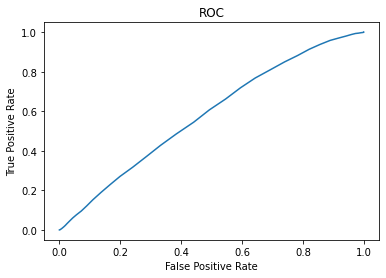

In [8]:
train_X, train_y = prepare_dataset(train_dataset_pd, cols=["key", "liveness", "valence", "tempo"])
test_X, test_y = prepare_dataset(test_dataset_pd, cols=["key", "liveness", "valence", "tempo"])

epochs = 250
lr = 0.1
w, losses = fit(epochs, lr, train_X, train_y)


predictions = predict(test_X, w)
class_predictions = threshold_predictions(predictions, 0.5)

fp, tp, auc = compute_ROC(predictions, test_y)
plt.plot(fp, tp)
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

print("AUC: ", auc)